In [2]:
import yaml
import torch
%load_ext autoreload
%autoreload 2
from aircraft_env import Location
from aircraft_env import AircraftEnv
from utils.units_converter import feet2meter

from itertools import product
from ddqn_agent.ddqnF_agent import DDQNFAgent
import numpy as np
with open('ddqn_agent/config.yaml') as f:
    templates = yaml.safe_load(f)
loc_1 = Location(45.46873715, -73.74257166095532)
loc_2 = Location(49.0068908, 2.5710819691019156)
loc_1, loc_2
env = AircraftEnv(arrival_location=loc_1, destination=loc_2, n_waypoints=9)
# agent = DQNAgent(templates, env=env, model_type=Net)
agent = DDQNFAgent(templates, env)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Actions Number 25


In [3]:
agent.train()

Episode: 29950| Epsilone: 0.207: 100%|██████████| 30000/30000 [05:26<00:00, 91.78it/s] 


In [ ]:
agent.init_new_episode(agent.env)
for i in range(2000):
    action = np.random.randint(agent.action_number)
    processed_action = agent.preprocess_action(action)
    next_observation, reward, done = agent.env.step(processed_action)
    next_state = agent.preprocess_state(next_observation)
    agent.replay_buffer.push((agent.state, action, reward, next_state, done))
    agent.state = next_state.copy()
    if done:
        agent.init_new_episode(agent.env)
#         self.rewards.append(episode_reward)
#         episode_reward = 0

In [ ]:
state, act, reward, next_state, done = \
    map(lambda x: np.array(x), agent.replay_buffer.sample(agent.minibatch))
o_state, o_act, o_reward, o_next_state, o_done = agent.transition_process(state, act, reward, next_state, done)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot((pd.Series(agent.rewards)).rolling(window=30).mean())

In [12]:
x = agent.replay_buffer.sample(1000)

(array([ 83.,  99., 107., 108., 121.,  98., 114.,  87.,  88.,  95.]),
 array([10000.13395519, 10184.04098694, 10367.94801869, 10551.85505044,
        10735.76208219, 10919.66911395, 11103.5761457 , 11287.48317745,
        11471.3902092 , 11655.29724095, 11839.2042727 ]),
 <BarContainer object of 10 artists>)

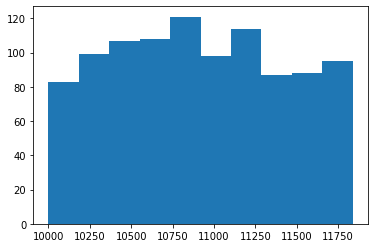

In [15]:
import matplotlib.pyplot as plt
plt.hist(np.array(x[0])[:, 2])

In [ ]:
agent.actions[agent.replay_buffer.sample(10)[1]]

In [4]:
from utils.env_extra import env_summary
df = env_summary(env, agent, random=False)
df

,trajectory,waypoint,speed,tas,distance,wind_magnitude,wind_direction,course,correction_angle,altitude,time_for_distance,fuel_burn,total_time,reward,fuel_flow,mach_number
0,2,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.00
1,2,1,235.732790,231.92607,692678.387980,3.930965,71.027558,56.703470,-0.240262,9600.0,2938.404918,1237.422432,2938.404918,762.577568,0.4211204606104921,0.77
2,2,2,230.809329,231.92607,692678.387980,5.769508,322.006729,62.465560,1.401777,9600.0,3001.084883,1263.818248,5939.489800,736.181752,0.4211204606104921,0.77
3,2,3,224.536498,231.92607,692678.387980,30.412114,328.880007,69.206522,7.412069,9600.0,3084.925585,1299.125283,9024.415385,700.874717,0.4211204606104921,0.77
4,2,4,224.257205,231.92607,692678.387980,39.637985,173.071102,76.847750,-9.782043,9600.0,3088.767597,1300.743233,12113.182982,699.256767,0.4211204606104921,0.77
5,2,5,200.906049,231.92607,692678.387980,44.530055,214.909090,85.149776,-8.487782,9600.0,3447.772692,1451.927624,15560.955674,548.072376,0.4211204606104921,0.77
6,1,6,206.617938,231.92607,694497.675821,26.444102,287.467590,89.580337,2.006938,9600.0,3361.265157,1415.497531,18922.220831,584.502469,0.4211204606104921,0.77
7,1,7,234.279262,231.92607,740511.322587,7.828844,176.332651,104.740468,-1.835417,9600.0,3160.806111,1331.080125,22083.026941,668.919875,0.4211204606104921,0.77
8,1,8,253.221145,231.92607,645768.368437,23.234822,134.395809,111.892295,-2.197469,9600.0,2550.215024,1073.947726,24633.241966,926.052274,0.4211204606104921,0.77


In [5]:
df['fuel_burn'].sum()

10373.562202936322

In [7]:
from utils.units_converter import mperstokt, feet2meter, meter2feet
env.aicraft.fuel_enroute(30000, mperstokt(230.586637), meter2feet(10000), 0)

array(0.40646676)

In [ ]:
env.aicraft.fuel_enroute(30000, mperstokt(230.586637), meter2feet(15000), 0)

9977.91666347273

In [ ]:
ps = agent.preprocess_state(env.state)

In [ ]:
ps

In [ ]:
agent.model(torch.autograd.Variable(torch.FloatTensor(ps).to('cuda:0').unsqueeze(0))).max(1)[1]

In [ ]:
plt.plot(pd.Series(agent.periodic_rewards).rolling(window=10).mean())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# pd.Series(agent.losses).rolling(window=1000).
plt.plot(pd.Series(agent.losses).rolling(window=100).mean())
plt.show()